In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchorsors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

Using TensorFlow backend.


In [2]:

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    
    
    #Computing the box scores
    box_scores = box_confidence * box_class_probs
     
    #Finding  the box_classes thanks to the max box_scores, keep track of the corresponding score
    box_classes = K.argmax(box_scores, axis=-1) 
    box_class_scores = K.max(box_scores, axis=-1) 
    
    # Creating a filtering mask based on "box_class_scores" by using "threshold"
  
    filtering_mask = box_class_scores >= threshold
    
    # Applying  mask to scores, boxes and classes
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes 

In [53]:

def iou(box1, box2):
   

    # Calculating the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)    

    # Calculating the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)

    box1_area = (box1[3]-box1[1])*(box1[2]-box1[0])
    box2_area = (box2[3]-box2[1])*(box2[2]-box2[0])
    union_area = box1_area+box2_area-inter_area
    
    # computing the IoU
    iou = inter_area  / union_area
     
    return iou

In [6]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')    
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Using tf.image.non_max_suppression() to get the list of indices corresponding to boxes 
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Using K.gather() to select only nms_indices from scores, boxes and classes

    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [8]:

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
       
    # Retrieving  outputs of the YOLO model 
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Converting boxes for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    #function(yolo_filter_boxes) for  Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scaling boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Using one of the yolo_non_max_suppression function to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
        
    return scores, boxes, classes 

## 3 - Test YOLO pretrained model on images

In [30]:
sess = K.get_session()

### 3.1 - Defining classes, anchors and image shape.

In [31]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

### 3.2 - Loading a pretrained model



In [32]:
yolo_model = load_model("model_data/yolo.h5")

/opt/conda/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [33]:
yolo_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 608, 608, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 608, 608, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 608, 608, 32)  128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 608, 608, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

### 3.3 - Convert output of the model to usable bounding box tensors



In [34]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))


### 3.4 - Filtering boxes

`yolo_outputs` gave  all the predicted boxes of `yolo_model` in the correct format. now ready to perform filtering and select only the best boxes. Lets now call `yolo_eval`, which you had previously implemented, to do this. 

In [35]:

scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### 3.5 - Run the graph on an image



In [50]:


def predict(sess, image_file):
   
    # Preprocessing  image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    # predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generating colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Drawin bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("out", image_file), quality=200)
    # The results in the notebook
    output_image = scipy.misc.imread(os.path.join("out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes



Found 7 boxes for test6.jpg
car 0.66 (1087, 389) (1024, 467)
car 0.69 (0, 443) (387, 632)
person 0.73 (753, 403) (830, 634)
car 0.76 (358, 374) (608, 452)
person 0.78 (569, 413) (681, 654)
person 0.79 (925, 403) (1024, 640)
car 0.80 (364, 501) (614, 618)


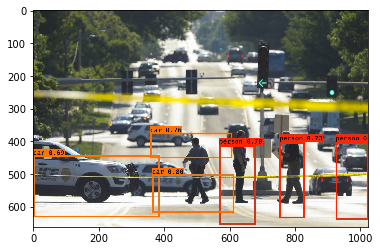

In [51]:
out_scores, out_boxes, out_classes = predict(sess, "test6.jpg")

Found 6 boxes for test3.png
person 0.60 (999, 128) (845, 379)
motorbike 0.61 (399, 247) (710, 440)
person 0.69 (100, 104) (256, 387)
motorbike 0.73 (980, 215) (845, 440)
person 0.76 (242, 70) (631, 440)
person 0.78 (722, 0) (845, 440)


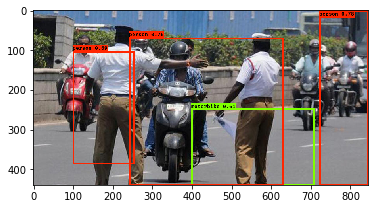

In [52]:
out_scores, out_boxes, out_classes = predict(sess, "test3.png")